## Deep Learning Models
in this notebook, We will build deep learning models to try to get higher performance in classifying comments into positive and negative.

In [ ]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve, auc

In [ ]:
# read dataset
data = pd.read_csv('/content/drive/MyDrive/classification_reviews/data/amazon_cleaned.csv')

# show the first 20 rows
data.head(20)

,Unnamed: 0,label,cleaned_text
0,65005,-1,حب تر تان قرأ كتب منتشر لي ناس تتكلم عن قصد عد...
1,6736,1,حمل قع
2,63032,-1,كتاب صغح تلخص كل دا صفح كرار طريق ظيع درج ني ق...
3,2990,1,استثنائ جميل جد موقع استراتيجي
4,50213,-1,موحش رهيب مليء حشر ذهب مرة خرى قع فندق جوار طي...
5,30288,1,نهي تو هو قاتل مي معلوف كتاب جيد جد لكن حب نظر...
6,6650,1,جميل شيء
7,6016,1,استثنائ موقع
8,7515,1,تاب قرأ غاز قصيب وقف عند معقد قصوص تب على قصوص...
9,19413,1,بدو هاروكى مبيعرفش كتب روا حط تاتش فانتازي تاع...


In [ ]:
# drop column
data.drop('Unnamed: 0', axis=1, inplace=True)
data = data.fillna('')
data.reset_index(drop=True, inplace=True)

# show the first 5 rows
data.head()

,label,cleaned_text
0,-1,حب تر تان قرأ كتب منتشر لي ناس تتكلم عن قصد عد...
1,1,حمل قع
2,-1,كتاب صغح تلخص كل دا صفح كرار طريق ظيع درج ني ق...
3,1,استثنائ جميل جد موقع استراتيجي
4,-1,موحش رهيب مليء حشر ذهب مرة خرى قع فندق جوار طي...


In [ ]:
# Extract the preprocessed text and labels from the data
X = data['cleaned_text']
y = data['label']

# Create a label encoder to convert class labels to numerical values
label_encoder = LabelEncoder()

# Encode the class labels into numerical values
y = label_encoder.fit_transform(y)

### Split the data into training and testing sets

*   X_train: Features for training

*   X_test: Features for testing

*   y_train: Numerical encoded labels for training

*   y_test: Numerical encoded labels for testing

The 'test_size' parameter specifies the proportion of the data to be used for testing


The 'random_state' parameter is used to ensure reproducibility of the split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Define the maximum number of words to be considered in the tokenizer
max_words = 1663

# Create a tokenizer and fit it on the training text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert the training text data into sequences of tokens
X_train_tokens = tokenizer.texts_to_sequences(X_train)

# Convert the testing text data into sequences of tokens using the same tokenizer
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Define the maximum sequence length for padding and truncation
max_seq_length = 1663

# Pad the training sequences to have a uniform length
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_seq_length, padding='post', truncating='post')

# Pad the testing sequences using the same maximum sequence length
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_seq_length, padding='post', truncating='post')

In [ ]:
# Define the binary classification model using a Sequential API
binary_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length),  # Embedding layer
    Conv1D(128, 5, activation='relu'),  # 1D Convolutional layer
    GlobalMaxPooling1D(),  # Global Max Pooling layer
    Dense(64, activation='relu'),  # Fully connected Dense layer
    Dropout(0.5),  # Dropout layer for regularization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the binary classification model
binary_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Define learning rate reduction when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Display the summary of the binary classification model
binary_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1663, 128)         212864    
                                                                 
 conv1d_2 (Conv1D)           (None, 1659, 128)         82048     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
# Train the binary classification model with training data and validate using a validation split
history = binary_model.fit(X_train_padded, y_train, validation_split=0.1, epochs=10, batch_size=32,
                            callbacks=[early_stopping, reduce_lr])

# Predict probabilities using the trained binary classification model on the test data
y_pred = binary_model.predict(X_test_padded)

# Convert probabilities to binary class predictions (0 or 1) using rounding
y_pred_classes = np.round(y_pred)

# Convert numerical labels back to their original class labels
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes.astype(int))

# Generate a classification report to evaluate the model's performance
classification_rep = classification_report(y_test_original, y_pred_original)

# Print the classification report to the console
print("Classification Report:\n", classification_rep)

Epoch 1/10
1688/1688 [==============================] - 88s 52ms/step - loss: 0.4137 - accuracy: 0.8013 - val_loss: 0.3765 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 2/10
1688/1688 [==============================] - 36s 21ms/step - loss: 0.3312 - accuracy: 0.8536 - val_loss: 0.3680 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 3/10
1688/1688 [==============================] - 30s 18ms/step - loss: 0.2699 - accuracy: 0.8856 - val_loss: 0.3868 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 4/10
209/209 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3340
           1       0.85      0.79      0.82      3327

    accuracy                           0.83      6667
   macro avg       0.83      0.83      0.83      6667
weighted avg       0.83      0.83      0.83      6667



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# show f1_score
print(f1_score(y_test_original, y_pred_original))

0.8198970840480274


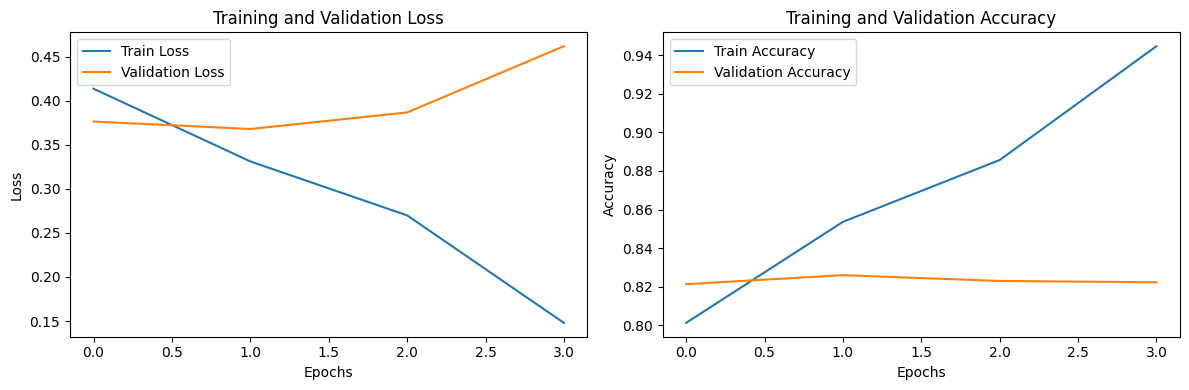

In [ ]:
# Create a figure with two subplots for loss and accuracy visualization
plt.figure(figsize=(12, 4))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
# save the model
binary_model.save('/content/drive/MyDrive/classification_reviews/models/CNN_model1')

In [ ]:
# Create a label encoder to convert class labels to numerical values
label_encoder = LabelEncoder()

# Encode the class labels into numerical values
data['label'] = label_encoder.fit_transform(data['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.1, random_state=42)

# Define the maximum number of words and maximum sequence length
max_words = 10000
max_len = 100

# Create a tokenizer and fit it on the training text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert the training text data into sequences of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)

# Pad the training sequences to have a uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

# Convert the testing text data into sequences of tokens using the same tokenizer
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the testing sequences using the same maximum sequence length
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Create a sequential model
model = Sequential()

# Add an embedding layer to the model
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))

# Add an LSTM layer to the model
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))

# Add a dense output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Define learning rate, batch size, and number of epochs
learning_rate = 0.001
batch_size = 64
epochs = 10

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compile the model using binary cross-entropy loss and the specified optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model using the training data and validate on the testing data
history = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test_pad, y_test))

Epoch 1/10
938/938 [==============================] - 613s 648ms/step - loss: 0.4011 - accuracy: 0.8137 - val_loss: 0.3400 - val_accuracy: 0.8475
Epoch 2/10
938/938 [==============================] - 473s 504ms/step - loss: 0.2962 - accuracy: 0.8727 - val_loss: 0.3412 - val_accuracy: 0.8496
Epoch 3/10
938/938 [==============================] - 464s 495ms/step - loss: 0.2461 - accuracy: 0.8981 - val_loss: 0.3618 - val_accuracy: 0.8481
Epoch 4/10
938/938 [==============================] - 462s 492ms/step - loss: 0.2034 - accuracy: 0.9166 - val_loss: 0.3839 - val_accuracy: 0.8418
Epoch 5/10
938/938 [==============================] - 449s 479ms/step - loss: 0.1688 - accuracy: 0.9325 - val_loss: 0.4707 - val_accuracy: 0.8412
Epoch 6/10
938/938 [==============================] - 450s 480ms/step - loss: 0.1418 - accuracy: 0.9446 - val_loss: 0.4669 - val_accuracy: 0.8305
Epoch 7/10
938/938 [==============================] - 450s 480ms/step - loss: 0.1210 - accuracy: 0.9547 - val_loss: 0.5320 -

In [ ]:
# Predict probabilities using the trained LSTM model on the test data
y_pred_ls = model.predict(X_test_pad)

# Convert probabilities to binary class predictions (0 or 1) using rounding
y_pred_ls = np.round(y_pred_ls)

# Convert numerical labels back to their original class labels
y_test_ls = label_encoder.inverse_transform(y_test)
y_pred_lstm = label_encoder.inverse_transform(y_pred_ls.astype(int))

# Generate a classification report to evaluate the LSTM model's performance
classification_rep_lstm = classification_report(y_test_ls, y_pred_lstm)

# Print the classification report to the console
print("LSTM Classification Report:\n", classification_rep_lstm)

209/209 [==============================] - 8s 37ms/step
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3340
           1       0.85      0.80      0.82      3327

    accuracy                           0.83      6667
   macro avg       0.83      0.83      0.83      6667
weighted avg       0.83      0.83      0.83      6667



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# show f1_score
print(f1_score(y_test_ls, y_pred_lstm))

0.8237482560843281


In [ ]:
# save the model
model.save('/content/drive/MyDrive/classification_reviews/models/lstm_model1')

The  CNN and lstm that we built did not achieve the required performance and we were not able to obtain higher performance than the performance of previous machine learning algorithms, so we will create a final notebook in which we will use other deep learning networks.